## packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cart
import pyresample
import warnings
warnings.filterwarnings('ignore')

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# Read grid and masks

In [2]:
# define basin we want - here 6 is for Barents
# we can look directly at the layers output if we want to:
#  cd /scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/
iB = 6   # see mskBasin if you want for later; maybe we should write this to file

In [3]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"
dirtrsp = dirDiags + "TRSP/"

In [4]:
bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

In [5]:
# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

In [6]:
# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

In [7]:
# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

(50,) (50, 1350, 270)


In [8]:
mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

hf1 (1350, 270)
shape of tracer fld: (1, 900, 540)
(1, 1350, 270)
compact shape (1, 1350, 270)


In [9]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

In [10]:
# write the wet mask and also set to nan
wetmask = mygrid['hFacC']
print(wetmask.shape)
wetmask_tracer = get_aste_tracer(wetmask,nfx,nfy)
print("hey",wetmask_tracer.shape)
wetmask_tracer[:,450:,:270] = np.nan
wetmask = aste_tracer2compact(wetmask_tracer,nfx,nfy)
print(wetmask.shape)

(50, 1350, 270)
hey (50, 900, 540)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
(50, 1350, 270)


In [11]:
dims = ("z","compact_x","compact_y")
coords = {"z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsBasin = {'title' : 'CanadaB: 0, ChukchiS: 1, MakarovB: 2, AmundsenB: 3, NansenB: 4, BeringS: 5, BarentsS: 6, GINs: 7, CAA: 8, SPG: 9, LabSea: 10, NPac: 11, NAtlantic: 12, AtlS30: 13',
              'standard_name' : 'Basins labeled',
             'units' : 'degree_c'}

attrsWet= {'title' : 'model wet points in compact form',
         'standard_name' : '1= wet, 0=dry',
         'units' : 'boolean'}

# add mskBasin and wetmask to the xarray for the dataset
mskBasin_3D = xr.DataArray(data = mskBasin*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsBasin)

mskBasin_2D = xr.DataArray(data = mskBasin*wetmask[0,:,:],
                    dims = dims[1:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = attrsBasin)

wetmask_xr = xr.DataArray(data = wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsWet)


ds = xr.Dataset()
ds['mskBasin_3D'] = mskBasin_3D
ds['mskBasin_2D'] = mskBasin_2D
ds['wetmask'] = wetmask_xr

In [12]:
# get the number of points in the basin and we can use this as a mask for later
mymsk = mskBasin.copy()
mymsk[mymsk != iB] = np.nan
npoints = len(np.where(mymsk == iB)[0])   # set number of points in the basin to be used later
print(npoints)

10650


### Get timesteps and dt

In [13]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
times["2014"] = np.arange(12,13,1)
times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

In [14]:
# ocean and ice
AB_gT=0
AB_gS=0
debug = False

In [15]:
# ffac = 1e-6
ffac = 1

In [16]:
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
dt

2678400.0

In [17]:
tsstr[1]

'0000683712'

# Read in 2D and 3D fields - let's do all of them in the budgeting files
5/9 - changed to read in as much as possible

In [18]:
# for volume tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN','SIheff','SIhsnow','SIarea'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
ETANs = np.zeros((len(tsstr), ny, nx))
SIheffs = np.zeros((len(tsstr), ny, nx))
SIhsnows = np.zeros((len(tsstr), ny, nx))
SIareas = np.zeros((len(tsstr), ny, nx))

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta   = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])
    SIheff,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])
    SIhsnow,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[2])
    SIarea,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[3])

    # choose by basin
    ETAN   = np.reshape(ETAN,(ny,nx)) * wetmask[0,:,:]
    SIheff = np.reshape(SIheff,(ny,nx)) * wetmask[0,:,:]
    SIhsnow = np.reshape(SIhsnow,(ny,nx)) * wetmask[0,:,:]
    SIarea = np.reshape(SIarea,(ny,nx)) * wetmask[0,:,:]

    # set to array
    ETANs[t,:,:] = ETAN
    SIheffs[t,:,:] = SIheff
    SIhsnows[t,:,:] = SIhsnow
    SIareas[t,:,:] = SIarea
    
    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol

print(vol.shape)

# do volume (not mass) tendency
voltend = vol[1,:,:,:] - vol[0,:,:,:]         # m^3/month
voltend = voltend/int(dt)                          # m^3/s

(2, 50, 1350, 270)


In [19]:
# horizontal convergence terms for U and V mass
meta_budg3d_hflux_set2= parsemeta(dirIn + "budg3d_hflux_set2" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg3d_hflux_set2['fldList'])
varnames = np.array(['UVELMASS','VVELMASS'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
UVELMASS,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[0])       # m/s
VVELMASS,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[1])       # m/s

# read advective
meta_budg2d_hflux_set1= parsemeta(dirIn + "budg2d_hflux_set1" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg2d_hflux_set1['fldList'])
varnames = np.array(['ADVxHEFF','ADVyHEFF','ADVxSNOW','ADVySNOW'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(dirIn + "budg2d_hflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[0])       # m.m^2/s    ice 
ADVyHEFF,its,meta = rdmds(dirIn + "budg2d_hflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[1])       # m.m^2/s    ice 
ADVxSNOW,its,meta = rdmds(dirIn + "budg2d_hflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[2])       # m.m^2/s    snow
ADVySNOW,its,meta = rdmds(dirIn + "budg2d_hflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[3])

# reshaping
UVELMASS = UVELMASS.reshape(nz,ny,nx) #* wetmask[:,:,:] * mymsk[np.newaxis,:,:]
VVELMASS = VVELMASS.reshape(nz,ny,nx) #* wetmask[:,:,:] * mymsk[np.newaxis,:,:]
ADVxHEFF = ADVxHEFF.reshape(ny,nx)
ADVyHEFF = ADVyHEFF.reshape(ny,nx)
ADVxSNOW = ADVxSNOW.reshape(ny,nx)
ADVySNOW = ADVySNOW.reshape(ny,nx)

In [20]:
# vertical convergence terms for mass
meta_budg2d_zflux_set1= parsemeta(dirIn + "budg2d_zflux_set1" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg2d_zflux_set1['fldList'])
varnames = np.array(['oceFWflx','SIatmFW'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
# net surface Fresh-Water flux into the ocean (+=down), >0 decreases salinity
oceFWflx,its,meta = rdmds(dirIn + "budg2d_zflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[0])
# Net freshwater flux from atmosphere & land (+=down)
SIatmFW,its,meta = rdmds(dirIn + "budg2d_zflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[1])

# read WVELMASS
meta_budg3d_zflux_set2= parsemeta(dirIn + "budg3d_zflux_set2" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg3d_zflux_set2['fldList'])
varnames = np.array(['WVELMASS'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
# Vertical Mass-Weighted Comp of Velocity
WVELMASS,its,meta = rdmds(dirIn + "budg3d_zflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[0])

oceFWflx = oceFWflx.reshape(ny,nx)  # * wetmask[0,:,:] * mymsk                       # kg/m^2/s
# SIatmFW = SIatmFW.reshape(ny,nx) * wetmask[0,:,:] * mymsk                         # kg/m^2/s
WVELMASS = WVELMASS.reshape(nz,ny,nx)

In [21]:
# read in the initial model T-S fields
# create an array to store the values at all time steps
fileTS = np.zeros((len(tsstr),2,nz,ny,nx))

# read each of the files from the list
for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = int(t1)

    # read the file
    thisfileTS = rdmds(dirIn + "budg3d_snap_set2",read)    # dr values, z, y, x
    thisfldListTS = parsemeta(dirIn + "budg3d_snap_set2." + tsstr[t] + ".meta")["fldList"]
    
    thisfileTS = thisfileTS.reshape(2,nz, ny, nx)

    fileTS[t,:,:,:,:] = thisfileTS

# we should unweight these before we add them to the dataset
DRF3d = mk3D_mod(mygrid["DRF"],np.zeros((nz, ny, nx)))
# temp = fileTS[:,0,:,:,:] / DRF3d
# salt = fileTS[:,1,:,:,:] / DRF3d

In [22]:
np.nanmax(mymsk)

6.0

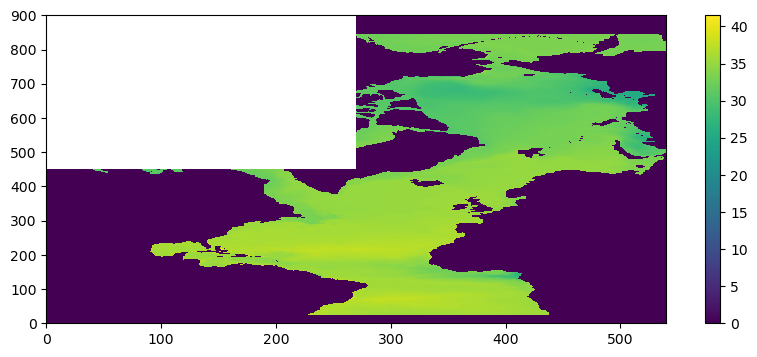

In [23]:
plt.pcolormesh(get_aste_tracer(thisfileTS[1]/DRF3d,nfx,nfy)[0])
plt.colorbar()

In [24]:
# read in the initial model T-S fields
# create an array to store the values at all time steps
fileTS = np.zeros((len(tsstr),2,nz,ny,nx))
temps = np.full((len(tsstr),nz,ny,nx),np.nan)
salts = np.full((len(tsstr),nz,ny,nx),np.nan)

DRF3d = mk3D_mod(mygrid["DRF"],np.zeros((nz, ny, nx)))

# read each of the files from the list
for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = int(t1)

    # read the file
    thisfileTS = rdmds(dirIn + "budg3d_snap_set2",read)    # dr values, z, y, x
    thisfldListTS = parsemeta(dirIn + "budg3d_snap_set2." + tsstr[t] + ".meta")["fldList"]

    mytemp = thisfileTS[0]
    temps[t,:,:,:] = mytemp.reshape(nz,ny,nx)/DRF3d

    mysalt = thisfileTS[1]
    salts[t,:,:,:] = mysalt.reshape(nz,ny,nx)/DRF3d

    #print(thisfileTS.shape)
    #thisfileTS = thisfileTS.reshape(2,nz, ny, nx)

    #fileTS[t,:,:,:,:] = thisfileTS

# we should unweight these before we add them to the dataset

(400.0, 600.0)

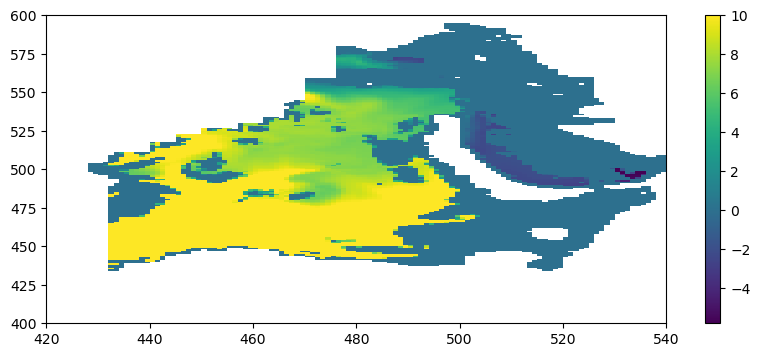

In [25]:
plt.pcolormesh(get_aste_tracer(temps[0,15]*mymsk,nfx,nfy)[0],vmax=10)
plt.colorbar()
plt.xlim(420,540)
plt.ylim(400,600)

In [26]:
mygrid["hFacC"].shape

(50, 1350, 270)

In [27]:
# try to initialize the dataset with XC and YC rather than arange values
XC = mygrid["XC"]
YC = mygrid["YC"]
Depth = mygrid["Depth"]

XC = xr.DataArray(XC,dims = ["compact_y","compact_x"], coords = {"compact_y" : np.arange(0,1350,1),"compact_x" : np.arange(0,270,1)})
YC = xr.DataArray(YC,dims = ["compact_y","compact_x"], coords = {"compact_y" : np.arange(0,1350,1),"compact_x" : np.arange(0,270,1)})
Depth = xr.DataArray(Depth,dims = ["compact_y","compact_x"], coords = {"compact_y" : np.arange(0,1350,1),"compact_x" : np.arange(0,270,1)})

ds['hFacS'] = xr.DataArray(data = mygrid['hFacS'], dims = ["z","compact_y","compact_x"], coords = {"z": np.arange(0,50,1),
                                                                                                   "compact_y" : np.arange(0,1350,1),
                                                                                                   "compact_x" : np.arange(0,270,1)})
ds['hFacC'] = xr.DataArray(data = mygrid['hFacC'], dims = ["z","compact_y","compact_x"], coords = {"z": np.arange(0,50,1),
                                                                                                   "compact_y" : np.arange(0,1350,1),
                                                                                                   "compact_x" : np.arange(0,270,1)})

In [28]:
ds = xr.Dataset()

# set dataset for snap data
dims2d = ("iteration","compact_y","compact_x")
dims3d = ("iteration","z","compact_y","compact_x")

coords2d = {"iteration":datetimes,
          "compact_y" : np.arange(0,1350,1),
          "compact_x" : np.arange(0,270,1)}

coords3d = {"iteration":datetimes,
          "z": np.arange(0,50,1),
          "compact_y" : np.arange(0,1350,1),
          "compact_x" : np.arange(0,270,1)}

ds["theta"] = xr.DataArray(data = temps,dims=dims3d,coords=coords3d)
ds["salinity"] = xr.DataArray(data = salts,dims=dims3d,coords=coords3d)

ds["ETAN"] = xr.DataArray(data = ETANs, dims = dims2d,coords = coords2d)
ds["SIheff"] = xr.DataArray(data = SIheffs, dims = dims2d,coords = coords2d)
ds["SIhsnow"] = xr.DataArray(data = SIhsnows, dims = dims2d,coords = coords2d)
ds["SIarea"] = xr.DataArray(data = SIareas, dims = dims2d,coords = coords2d)

In [29]:
# set dataset for averaged data

# set dataset for snap data
dims2d_avg = ("compact_y","compact_x")
dims3d_avg = ("z","compact_y","compact_x")

coords2d_avg = {"compact_y" : np.arange(0,1350,1),
          "compact_x" : np.arange(0,270,1)}

coords3d_avg = {"z" : np.arange(0,50,1),
            "compact_y" : np.arange(0,1350,1),
          "compact_x" : np.arange(0,270,1)}

ds["UVELMASS"] = xr.DataArray(data = UVELMASS, dims = dims3d_avg,coords = coords3d_avg)
ds["VVELMASS"] = xr.DataArray(data = VVELMASS, dims = dims3d_avg,coords = coords3d_avg)
ds["ADVxHEFF"] = xr.DataArray(data = ADVxHEFF, dims = dims2d_avg,coords = coords2d_avg)
ds["ADVyHEFF"] = xr.DataArray(data = ADVyHEFF, dims = dims2d_avg,coords = coords2d_avg)
ds["ADVxSNOW"] = xr.DataArray(data = ADVxSNOW, dims = dims2d_avg,coords = coords2d_avg)
ds["ADVySNOW"] = xr.DataArray(data = ADVySNOW, dims = dims2d_avg,coords = coords2d_avg)

In [30]:
ds.coords["XC"] = XC
ds.coords["YC"] = YC
ds.coords["Depth"] = Depth

### Load 2D advective and diffusive of temp and salt, this can be to test vector

In [31]:
landmsk = np.full(mygrid['hFacC'].shape, np.nan)
landmsk[np.isnan(mygrid['hFacC'])] = 1
landmsk[~np.isnan(mygrid['hFacC'])] = np.nan

In [32]:
title1 = datetimes[0].strftime("%m/%d/%Y")
title2 = datetimes[1].strftime("%m/%d/%Y")

In [33]:
hfw = mygrid["hFacW"]
hfs = mygrid["hFacS"]
hfwaste,hfsaste=get_aste_vector(hfw,hfs,nfx,nfy,True)

In [34]:
file_name = 'trsp_2d_set1'

# assuming all files are structured the same
meta_trsp_2d_set1 = parsemeta(dirtrsp + file_name + "." + tsstr[1]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_trsp_2d_set1['fldList'])
print(fldlist)
varnames = fldlist.copy()
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

DFxE_TH,its,meta = rdmds(dirtrsp + file_name, int(tsstr[1]),returnmeta=True,rec = recs[0])
DFyE_TH,its,meta = rdmds(dirtrsp + file_name, int(tsstr[1]),returnmeta=True,rec = recs[1])
ADVx_TH,its,meta = rdmds(dirtrsp + file_name, int(tsstr[1]),returnmeta=True,rec = recs[2])
ADVy_TH,its,meta = rdmds(dirtrsp + file_name, int(tsstr[1]),returnmeta=True,rec = recs[3])
DFxE_SLT,its,meta = rdmds(dirtrsp + file_name, int(tsstr[1]),returnmeta=True,rec = recs[4])
DFyE_SLT,its,meta = rdmds(dirtrsp + file_name, int(tsstr[1]),returnmeta=True,rec = recs[5])
ADVx_SLT,its,meta = rdmds(dirtrsp + file_name, int(tsstr[1]),returnmeta=True,rec = recs[6])
ADVy_SLT,its,meta = rdmds(dirtrsp + file_name, int(tsstr[1]),returnmeta=True,rec = recs[7])

['DFxE_TH' 'DFyE_TH' 'ADVx_TH' 'ADVy_TH' 'DFxE_SLT' 'DFyE_SLT' 'ADVx_SLT'
 'ADVy_SLT']


In [35]:
DFxE_TH = DFxE_TH.reshape(ny,nx)
DFyE_TH = DFyE_TH.reshape(ny,nx)
ADVx_TH = ADVx_TH.reshape(ny,nx)
ADVy_TH = ADVy_TH.reshape(ny,nx)
DFxE_SLT = DFxE_SLT.reshape(ny,nx)
DFyE_SLT = DFyE_SLT.reshape(ny,nx)
ADVx_SLT = ADVx_SLT.reshape(ny,nx)
ADVy_SLT = ADVy_SLT.reshape(ny,nx)

In [36]:
# add to dataset
dims2d_avg
coords2d_avg

ds["DFxE_TH_2D"] = xr.DataArray(data = DFxE_TH, dims = dims2d_avg,coords = coords2d_avg)
ds["DFyE_TH_2D"] = xr.DataArray(data = DFyE_TH, dims = dims2d_avg,coords = coords2d_avg)
ds["ADVx_TH_2D"] = xr.DataArray(data = ADVx_TH, dims = dims2d_avg,coords = coords2d_avg)
ds["ADVy_TH_2D"] = xr.DataArray(data = ADVy_TH, dims = dims2d_avg,coords = coords2d_avg)
ds["DFxE_SLT_2D"] = xr.DataArray(data = DFxE_SLT, dims = dims2d_avg,coords = coords2d_avg)
ds["DFyE_SLT_2D"] = xr.DataArray(data = DFyE_SLT, dims = dims2d_avg,coords = coords2d_avg)
ds["ADVx_SLT_2D"] = xr.DataArray(data = ADVx_SLT, dims = dims2d_avg,coords = coords2d_avg)
ds["ADVy_SLT_2D"] = xr.DataArray(data = ADVy_SLT, dims = dims2d_avg,coords = coords2d_avg)

#### Optional testing for the vector data

In [37]:
# DFxE_TH,DFyE_TH  = get_aste_vector(DFxE_TH,DFyE_TH,nfx,nfy,False)   # degC.m^3/s; zonal (x) and meridional (y) Diffusive Flux of Pot.Temperature
# DFxE_SLT,DFyE_SLT  = get_aste_vector(DFxE_SLT,DFyE_SLT,nfx,nfy,False)   # degC.m^3/s; zonal (x) and meridional (y) Diffusive Flux of Pot.Temperature

In [38]:
# ADVx_TH,ADVy_TH  = get_aste_vector(ADVx_TH,ADVy_TH,nfx,nfy,False)   # degC.m^3/s; zonal (x) and meridional (y) Diffusive Flux of Pot.Temperature
# ADVx_SLT,ADVy_SLT  = get_aste_vector(ADVx_SLT,ADVy_SLT,nfx,nfy,False)   # degC.m^3/s; zonal (x) and meridional (y) Diffusive Flux of Pot.Temperature

In [39]:
oceFWflx = oceFWflx.reshape(ny,nx) #* mymsk/iB
SIatmFW = SIatmFW.reshape(ny,nx) #* mymsk/iB
WVELMASS = WVELMASS.reshape(nz,ny,nx) #* mymsk[np.newaxis,:,:]/iB

# add to ds
ds["oceFWflx"] = xr.DataArray(data = oceFWflx, dims = dims2d_avg,coords = coords2d_avg)
ds["SIatmFW"] = xr.DataArray(data = SIatmFW, dims = dims2d_avg,coords = coords2d_avg)
ds["WVELMASS"] = xr.DataArray(data = WVELMASS, dims = dims3d_avg,coords = coords3d_avg)

In [40]:
t2 = int(tsstr[1])

In [41]:
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","oceQsw","SItflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
TFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[0])
oceQsw,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[1])
SItflux,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[2])

TFLUX = TFLUX.reshape(ny,nx) #* mymsk/iB  # W/m^2            |total heat flux (match heat-content variations), >0 increases theta
oceQsw = oceQsw.reshape(ny,nx) #* mymsk/iB # W/m^2           |net Short-Wave radiation (+=down), >0 increases theta
SItflux = SItflux.reshape(ny,nx) #* mymsk/iB # W/m^2         |Same as TFLUX but incl seaice (>0 incr T decr H)

In [42]:
# add these to the dataset
ds["TFLUX"] = xr.DataArray(data = TFLUX, dims = dims2d_avg,coords = coords2d_avg)
ds["oceQsw"] = xr.DataArray(data = oceQsw, dims = dims2d_avg,coords = coords2d_avg)
ds["SItflux"] = xr.DataArray(data = SItflux, dims = dims2d_avg,coords = coords2d_avg)

### Add mass budgeting items

In [43]:
# copy our hconv, zconv, tendency at the gateway
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN','SIheff','SIhsnow'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
tend = np.zeros((len(tsstr)-1,nz, ny, nx))
print(tend.shape)

for t in range(len(tsstr)-1):
    print(t)
    t1 = tsstr[t]
    t2 = tsstr[t+1]
    read = [int(t1),int(t2)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])
    SIheff,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])
    SIhsnow,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[2])

    # do differencing
    dETAN_dt =  (ETAN[1, :, :] - ETAN[0, :, :]) / dt  # change naming to dEtan_dt  m/s
    dSIheff_dt =  (SIheff[1, :, :] - SIheff[0, :, :]) / dt
    dSIhsnow_dt = (SIhsnow[1, :, :] - SIhsnow[0, :, :]) / dt

    # choose by basin
    # select by existing basin in mskBasin
    dETAN_dt = np.reshape(dETAN_dt,(ny,nx)) #* mymsk
    dSIheff_dt = np.reshape(dSIheff_dt,(ny,nx)) #* mymsk
    dSIhsnow_dt = np.reshape(dSIhsnow_dt,(ny,nx)) #* mymsk

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmptend = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmptend[0,:, :] = dETAN_dt * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmptend[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC
            tmp2 = tmp1/mk3D_mod(DD,tmp1)
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)
            
        tmptend = tmp2 * mk3D_mod(dETAN_dt, tmp2) * myparms['rhoconst'] * mk3D_mod(RAC, hfC)    # kg/s

    tend[t,:,:,:] = tmptend

tend = tend[0]
ds["mass_tend"] = xr.DataArray(data = tend, dims = dims3d_avg,coords = coords3d_avg)

(1, 50, 1350, 270)
0


In [44]:
tsstr

array(['0000679248', '0000683712'], dtype='<U32')

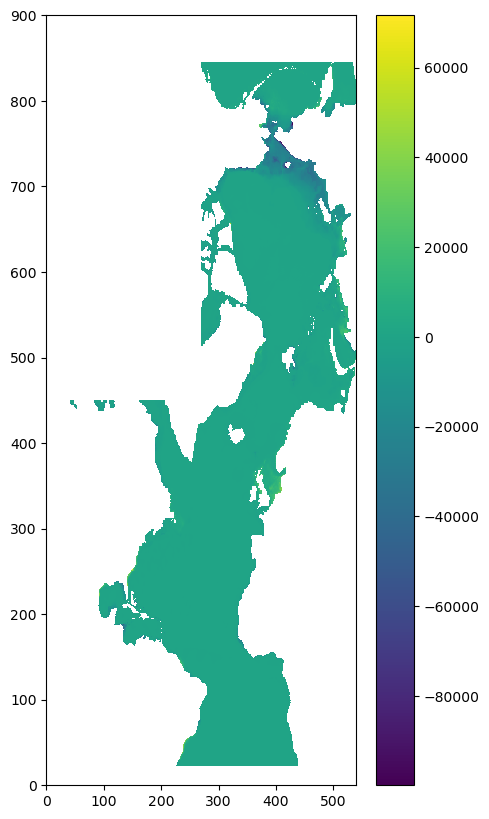

In [45]:
fig = plt.figure(figsize=(5,10))

ax = plt.subplot(111)

plt.pcolormesh(get_aste_tracer(tmptend[0],nfx,nfy)[0])
plt.colorbar()

In [46]:
# for heat tendency (J/s) - time not yet included here
# read the fldList
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# for each time step read the files
h_tend = np.zeros((len(tsstr),nz, ny, nx))
print("heat tendency allocation shape",h_tend.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    THETADR,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    THETADR = np.reshape(THETADR,(nz,ny,nx)) #* wetmask[:,:,:]

    tmpheat = myparms['rcp']*(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)  # J/(m^3*degC) * degC*m * m^2 = J
    
    h_tend[t,:,:,:] = tmpheat

print(h_tend.shape)
h_tend = (h_tend[-1] - h_tend[-2])/dt
ds["THETADR"] = xr.DataArray(data = THETADR, dims = dims3d_avg,coords = coords3d_avg)
ds["heat_tend"] = xr.DataArray(data = h_tend, dims = dims3d_avg,coords = coords3d_avg)

heat tendency allocation shape (2, 50, 1350, 270)
(2, 50, 1350, 270)


In [47]:
# for salt tendency (kg PSU/s) or (g/s) - time not yet included here
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# for each time step read the files
sal_tend = np.zeros((len(tsstr),nz, ny, nx))
print("heat tendency allocation shape",h_tend.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    SALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    SALTDR = np.reshape(SALTDR,(nz,ny,nx)) #* wetmask[:,:,:]

    tmpsalt = myparms['rhoconst'] * (SALTDR - AB_gS) * mk3D_mod(RAC,SALTDR)   # kg/m^3 * PSU*m * m^2 = kg*(g/kg) = g
    
    sal_tend[t,:,:,:] = tmpsalt

print(sal_tend.shape)

sal_tend = (sal_tend[-1] - sal_tend[-2])/dt
ds["SALTDR"] = xr.DataArray(data = SALTDR, dims = dims3d_avg,coords = coords3d_avg)
ds["salt_tend"] = xr.DataArray(data = sal_tend, dims = dims3d_avg,coords = coords3d_avg)

heat tendency allocation shape (50, 1350, 270)
(2, 50, 1350, 270)


In [92]:
# THERE IS NO DFXEHEFF OR DFYEHEFF! This has not been handled in this notebook
# Calculations for ocean
tmpUo = myparms['rhoconst'] * dyg3d * drf3d * ds.UVELMASS.values   # kg/s
tmpVo = myparms['rhoconst'] * dxg3d * drf3d * ds.VVELMASS.values   # kg/s
tmpUo_tracer = get_aste_tracer(tmpUo,nfx,nfy)
tmpVo_tracer = get_aste_tracer(tmpVo,nfx,nfy)

budgO_fluxes_hconv = calc_UV_conv_1face(tmpUo, tmpVo)
print(budgO_fluxes_hconv.shape)
ds["budgO_fluxes_hconv_mass"] = xr.DataArray(data = budgO_fluxes_hconv, dims = dims3d_avg,coords = coords3d_avg)

(50, 1350, 270)


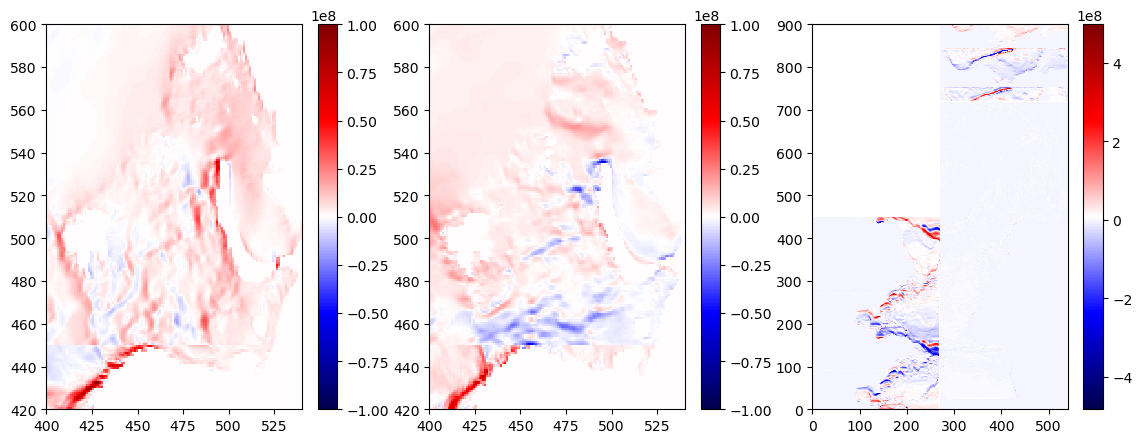

In [96]:
fig = plt.figure(figsize=(14,5))
ax = plt.subplot(131)
cb = ax.pcolormesh(get_aste_tracer(tmpUo,nfx,nfy)[0],cmap = 'seismic',vmin=-1e8,vmax=1e8)  # uvelmass
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(get_aste_tracer(tmpVo,nfx,nfy)[0],cmap = 'seismic',vmin=-1e8,vmax=1e8)  # vvelmass
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb)

ax = plt.subplot(133)
cb = ax.pcolormesh(get_aste_tracer(budgO_fluxes_hconv,nfx,nfy)[0],cmap = 'seismic')

plt.colorbar(cb)

In [49]:
# Perform calculations for zconv
budgO_zconv = oceFWflx

if not myparms["useRFWF"]:
    budgO_zconv = 0 * budgO_zconv

trWtop = -WVELMASS * myparms["rhoconst"]
print(trWtop.shape)

# indexing seems fishy here - rewrite
if myparms["useNLFS"] < 2 or myparms["rStar"] == 0:
    trWtop[0, :, :] = oceFWflx
    if not myparms["useRFWF"]:
        trWtop[0,:, :] = -WVELMASS[0,:, :] * myparms["rhoconst"]

# same size trWtop and TrWbot
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:, :] = trWtop[1:,:, :]

#budgO["fluxes"] = {}
budgO_fluxes_trWtop = trWtop * RAC3
budgO_fluxes_trWbot = trWbot * RAC3
budgO_fluxes_zconv = budgO_fluxes_trWtop - budgO_fluxes_trWbot

# changed axis here to 0 because we're looking at z
if myparms["useNLFS"] < 2 or (myparms["rStar"] == 0 and not myparms["useRFWF"]):
    budgO_zconv += np.sum(trWtop - trWbot, axis=0)

budgO_zconv = RAC * budgO_zconv
ds["budgO_fluxes_zconv_mass"] = xr.DataArray(data = budgO_fluxes_zconv, dims = dims3d_avg,coords = coords3d_avg)

(50, 1350, 270)


### add convergences for heat

In [50]:
# note: the following works provided that the first 3 terms are definitely there
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceQnet","WTHMASS","SIaaflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceQnet,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[0])
WTHMASS,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[1])
SIaaflux,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[2])

# note: will not work if these are defined, fix for future steps
varnames = np.array(["TRELAX","SIabflux","SIacflux","SIeprflx","SIfldflx"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

if len(recs) == 0:
    TRELAX = np.zeros((ny,nx))
    SIabflux = np.zeros((ny, nx))
    SIacflux = np.zeros((ny, nx))
    SIeprflx = np.zeros((ny, nx))
    SIfldflx = np.zeros((ny, nx))

if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WTHMASS=0*WTHMASS

geothFlux = 0

if myparms['SaltPlumeHeatFlux']:
    print(1)
else:
    SPforcT1=0*np.ones((ny,nx))
    oceEPtnd=0*np.ones((nz,ny,nx))

# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["KPPg_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
KPPg_TH,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[0])
KPPg_TH = KPPg_TH.reshape(nz,ny,nx)

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_TH","DFrE_TH","DFrI_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[0])
DFrE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[1])
DFrI_TH,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[2])

ADVr_TH = ADVr_TH.reshape(nz,ny,nx)
DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
DFrI_TH = DFrI_TH.reshape(nz,ny,nx)


budgO_zconv=TFLUX+geothFlux+SPforcT1

if myparms['useNLFS']==0:
    print(1)
    budgO_zconv=budgO_zconv-myparms['rcp']*WTHMASS[:,:]

In [51]:
if test3d:
    nr = mygrid['RC'].shape[0]
    trWtop = -(ADVr_TH+DFrE_TH+DFrI_TH+KPPg_TH)*myparms['rcp']
    dd = mygrid['RF'][:-1]
    swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
    swfrac[dd < -200] = 0
    swtop=mk3D_mod(swfrac,trWtop)*mk3D_mod(RAC*oceQsw,trWtop)
    mskC=mygrid['mskC']
    swtop[np.isnan(mskC)]=0
    trWtop=trWtop+swtop  # 323

    if myparms['SaltPlumeHeatFlux']:
        tmp1 = mk3D_mod(SPforcT1,oceEPtnd) - np.cumsum(oceEPtnd,axis=0)*RAC3
        trWtop[1:,:,:] = trWtop[1:,:,:] + tmp1[1:,:,:]
        
    trWtop[0,:,:]=budgO_zconv*RAC
    trWbot = np.zeros_like(trWtop)
    trWbot[:-1,:,:]=trWtop[1:,:,:]
    
    budgO_fluxes_trWtop = trWtop
    budgO_fluxes_trWbot = trWbot


budgO_fluxes_zconv_heat=budgO_fluxes_trWtop-budgO_fluxes_trWbot
ds["budgO_fluxes_zconv_heat"] = xr.DataArray(data = budgO_fluxes_zconv_heat, dims = dims3d_avg,coords = coords3d_avg)

In [52]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","DFxE_TH","DFyE_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[1])
DFxE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[2])
DFyE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[3])

ADVx_TH = ADVx_TH.reshape(nz,ny,nx)
ADVy_TH = ADVy_TH.reshape(nz,ny,nx)
DFxE_TH = DFxE_TH.reshape(nz,ny,nx)
DFyE_TH = DFyE_TH.reshape(nz,ny,nx)

tmpUo = myparms['rcp'] * (ADVx_TH + DFxE_TH)
tmpVo = myparms['rcp'] * (ADVy_TH + DFyE_TH)

if test3d:
    budgO_fluxes_hconv = calc_UV_conv_1face(tmpUo,tmpVo)

ds["budgO_fluxes_hconv_heat"] = xr.DataArray(data = budgO_fluxes_hconv, dims = dims3d_avg,coords = coords3d_avg)

# Load gateways

In [53]:
# get the number of points in the basin and we can use this as a mask for later
mymsk = mskBasin.copy()
mymsk[mymsk != iB] = np.nan
npoints = len(np.where(mymsk == iB)[0])   # set number of points in the basin to be used later
print(npoints)

10650


In [54]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('RdBu_r',51).copy()
cmap.set_under(color='white')

In [55]:
# 2d
inf = h5py.File(dirgridw + 'Index_wet_hfacC_2D.mat')
arr = inf['ind'][:]
iwetC2d = arr[5,:]
iwetC2d = iwetC2d.astype("int32")
iwetC2d -= 1
LwetC2d = iwetC2d.shape[0]
print("LwetC2d",LwetC2d)

# 3d
inf = h5py.File(dirgridw + "Index_wet_hfacC.mat")
arr = inf['ind'][:]
iwetC = arr[5,:]
iwetC = iwetC.astype("int32")
LwetC = iwetC.shape[0]
print("LwetC",LwetC)

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]

# hf.shape - z, y, x
# hf1.shape - 1, y, x
hfflat = np.reshape(hf,hf.flatten().shape[0])
hf3d = hfflat[iwetC]

LwetC2d 146614
LwetC 4833023


In [56]:
# load the gateways
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])
    ggate  = inf['ggate']
    ggate2  = inf['ggate2']
    
num = 1
for i in ggate[0]:
    label = i[0][0][0]
    print(num,label)
    num += 1
print()

num = 1
for i in ggate2[0]:
    label = (i[0][0][-2])
    print(num,label)
    num += 1

1 ['FramStrait']
2 ['NaresStrait']
3 ['CAA']
4 ['BarrowStrait/LancasterSound']
5 ['BarentsSeaOpening']
6 ['Svalbard-FranzJosefIslands']
7 ['FranzJosefIslands-NovayaZemlya']
8 ['KaraStrait']
9 ['StAnnaTrough/Voronin/Vilkitshogo']
10 ['BeringStrait']
11 ['DenmarkStrait']
12 ['Iceland-FaroeI']
13 ['Faroe-Shetland']
14 ['GibraltarStrait']
15 ['DavisStrait']
16 ['FloridaStrait']
17 ['BeringSea']
18 ['SubPolarGyre']
19 ['LabradorSea']

1 ['NansenAmundsen']
2 ['AmundsenMakarov']
3 ['MakarovCBCK']
4 ['FramStraitNansen']
5 ['FramStraitAmundsen']
6 ['NaresStraitMakarov']
7 ['OSNAPeast']


In [57]:
# we have to first make a dictionary
gg = {}
ggate1 = ggate[0]
for mygate in ggate1:
    name = mygate[0][0][0][0]
    gg[name] = {}
    gg[name]['ix'] = mygate[0][0][1][0]
    gg[name]['jy'] = mygate[0][0][2][0]
    gg[name]['signu'] = mygate[0][0][3][0]
    gg[name]['signv'] = mygate[0][0][4][0]
    gg[name]['descr'] = mygate[0][0][5][0]

In [58]:
gg2 = {}
ggate2a = ggate2[0]
for mygate in ggate2a:
    name = mygate[0][0][4][0]
    gg2[name] = {}
    gg2[name]['ix'] = mygate[0][0][0][0]
    gg2[name]['jy'] = mygate[0][0][1][0]
    gg2[name]['signu'] = mygate[0][0][2][0]
    gg2[name]['signv'] = mygate[0][0][3][0]
    gg2[name]['descr'] = mygate[0][0][5][0]

In [59]:
# check with An to see if these are the same values
for igate in gg.keys():
    L = len(gg[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg[igate]['jy'][i] - 1) * nx + gg[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg[igate]['indwet'] = indwet
    gg[igate]['ivalid'] = ivalid

In [60]:
# check with An to see if these are the same values
for igate in gg.keys():
    L = len(gg[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg[igate]['jy'][i] - 1) * nx + gg[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg[igate]['indwet'] = indwet
    gg[igate]['ivalid'] = ivalid

In [61]:
# check with An to see if these are the same values
for igate in gg2.keys():
    L = len(gg2[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg2[igate]['jy'][i] - 1) * nx + gg2[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg2[igate]['indwet'] = indwet
    gg2[igate]['ivalid'] = ivalid

In [62]:
# For Barents we want these three
# gg['BarentsSeaOpening']
# gg['Svalbard-FranzJosefIslands']
# gg['FranzJosefIslands-NovayaZemlya']

In [63]:
x_bso = gg['BarentsSeaOpening']["ix"]   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]

x_sta_vilkit = gg['StAnnaTrough/Voronin/Vilkitshogo']["ix"]  #3
y_sta_vilkit = gg['StAnnaTrough/Voronin/Vilkitshogo']["jy"]

# set the one we want to plot
x_curr = x_bso.copy()
y_curr = y_bso.copy()

In [64]:
x_curr = np.delete(x_curr, 21)
y_curr = np.delete(y_curr, 21)

x_bso = np.delete(x_bso,21)
y_bso = np.delete(y_bso,21)


In [65]:
i_bso = np.full((1350,270),np.nan)
for i,j in zip(x_bso,y_bso):
    i_bso[j][i] = 1

i_sfj = np.full((1350,270),np.nan)
for i,j in zip(x_sfj,y_sfj):
    i_sfj[j][i] = 1

i_bso = np.full((1350,270),np.nan)
for i,j in zip(x_bso,y_bso):
    i_bso[j][i] = 1

# Try plotting one gateway

(array([430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
       443, 444, 445, 446, 447, 448, 449, 452, 453, 454, 455, 456, 457,
       458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470,
       471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483,
       484, 485, 486, 487, 488, 489, 490, 491, 492, 613]), array([433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433,
       433, 433, 433, 433, 433, 433, 433, 430, 430, 430, 430, 430, 430,
       430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430,
       430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430,
       430, 430, 430, 430, 430, 430, 430, 430, 430, 539]))


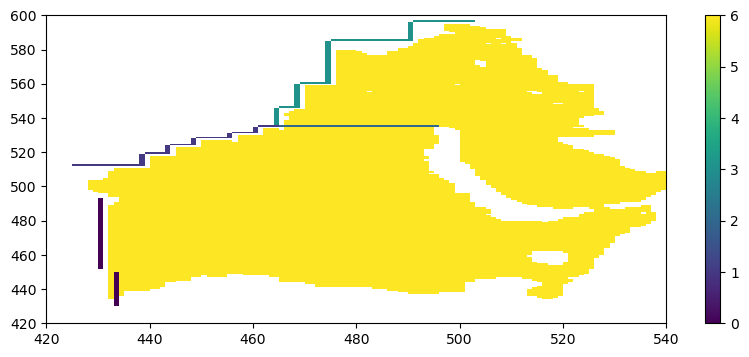

In [66]:
test = mymsk.copy()
test[y_sta_vilkit,x_sta_vilkit] = 3
test[y_fjnz,x_fjnz] = 2
test[y_sfj,x_sfj] = 1
test[y_bso,x_bso] = 0

plt.pcolormesh(get_aste_tracer(test,nfx,nfy)[0])
plt.xlim(420,540)
plt.ylim(420,600)
plt.colorbar()
mytest = np.where(get_aste_tracer(test,nfx,nfy)[0] ==0)
print(mytest)

In [67]:
# we need to get the perpendicular flow to the indicated gate
# define a function that looks to see if we are going lr or ud for each time
# if lr - perpendicular would be ud - y direction, vvelmass
# if ud - perpendicular would be lr - x direction, uvelmass
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations

choose_UV = line_orientation(mytest[1],mytest[0])
choose_UV = np.tile(choose_UV,(nz,1))
choose_UV[0].shape

(62,)

In [68]:
# create the velocity
vvelgate = ds.VVELMASS.values[:,y_curr,x_curr]
uvelgate = ds.UVELMASS.values[:,y_curr,x_curr]

perpendicular_vel = np.full(uvelgate.shape,np.nan) #    zeros_like(uvelgate)
print(perpendicular_vel.shape)
for i in range(len(choose_UV)):
    if choose_UV[i][0] == "V":
        perpendicular_vel[i] = -uvelgate[i]       # flipping the sign of this helps reproduce An plot but this seems wrong??
    elif choose_UV[i][0] == "H":
        perpendicular_vel[i] = -vvelgate[i]

(50, 62)


In [69]:
# try to isolate the areas along one gateway
gatemask = mygrid['hFacC'][:,y_curr,x_curr]
# this will be depth of cell * southern edge (mygrid['DXG']) if horizontal line or * western edge (mygrid['DYG']) if vertical)
dxggate = mygrid['DXG'][y_curr,x_curr]
dyggate = mygrid['DYG'][y_curr,x_curr]

# we make an array of the length of the cells
cell_lengths = np.full(uvelgate.shape[1],np.nan)
for i in range(len(choose_UV[0])):
    if choose_UV[0][i] == "V":
        cell_lengths[i] = dyggate[i] #DYG
    elif choose_UV[0][i] == "H":
        cell_lengths[i] = dxggate[i] #DXG

# print(np.nanmin(cell_lengths))
cell_lengths = np.tile(cell_lengths,(nz,1))
cell_area = cell_lengths * mygrid['DRF'].reshape(nz,1)

In [70]:
# select the advective and diffusive terms from here
# we have to select the advective in x and y
# this will be depth of cell * southern edge (mygrid['DXG']) if horizontal line or * western edge (mygrid['DYG']) if vertical)
DFxE_TH_2Dgate = ds.DFxE_TH_2D.values[y_curr,x_curr]
DFyE_TH_2Dgate = ds.DFyE_TH_2D.values[y_curr,x_curr]
DFxE_SLT_2Dgate = ds.DFxE_SLT_2D.values[y_curr,x_curr]
DFyE_SLT_2Dgate = ds.DFyE_SLT_2D.values[y_curr,x_curr]
ADVx_TH_2Dgate = ds.ADVx_TH_2D.values[y_curr,x_curr]
ADVy_TH_2Dgate = ds.ADVy_TH_2D.values[y_curr,x_curr]
ADVx_SLT_2Dgate = ds.ADVx_SLT_2D.values[y_curr,x_curr]
ADVy_SLT_2Dgate = ds.ADVy_SLT_2D.values[y_curr,x_curr]

# we make an array of the length of the cells
df_TH = np.full(uvelgate.shape[1],np.nan)
df_SLT = np.full(uvelgate.shape[1],np.nan)
adv_TH = np.full(uvelgate.shape[1],np.nan)
adv_SLT = np.full(uvelgate.shape[1],np.nan)

for i in range(len(choose_UV[0])):
    if choose_UV[0][i] == "V":
        df_TH[i] = DFxE_TH_2Dgate[i] #X flux
        df_SLT[i] = DFxE_SLT_2Dgate[i] #X flux
        adv_TH[i] = ADVx_TH_2Dgate[i]
        adv_SLT[i] = ADVx_SLT_2Dgate[i]

    elif choose_UV[0][i] == "H":
        df_TH[i] = DFyE_TH_2Dgate[i] #Y flux
        df_SLT[i] = DFyE_SLT_2Dgate[i] #Y flux
        adv_TH[i] = ADVy_TH_2Dgate[i]
        adv_SLT[i] = ADVy_SLT_2Dgate[i]

In [71]:
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [72]:
x_curr

array([163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163,
       163, 163, 163, 163, 163, 163, 163, 163,   2,   3,   4,   5,   6,
         7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42], dtype=uint8)

In [73]:
y_curr

array([430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
       443, 444, 445, 446, 447, 448, 449, 450, 559, 559, 559, 559, 559,
       559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559,
       559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559,
       559, 559, 559, 559, 559, 559, 559, 559, 559, 559], dtype=uint16)

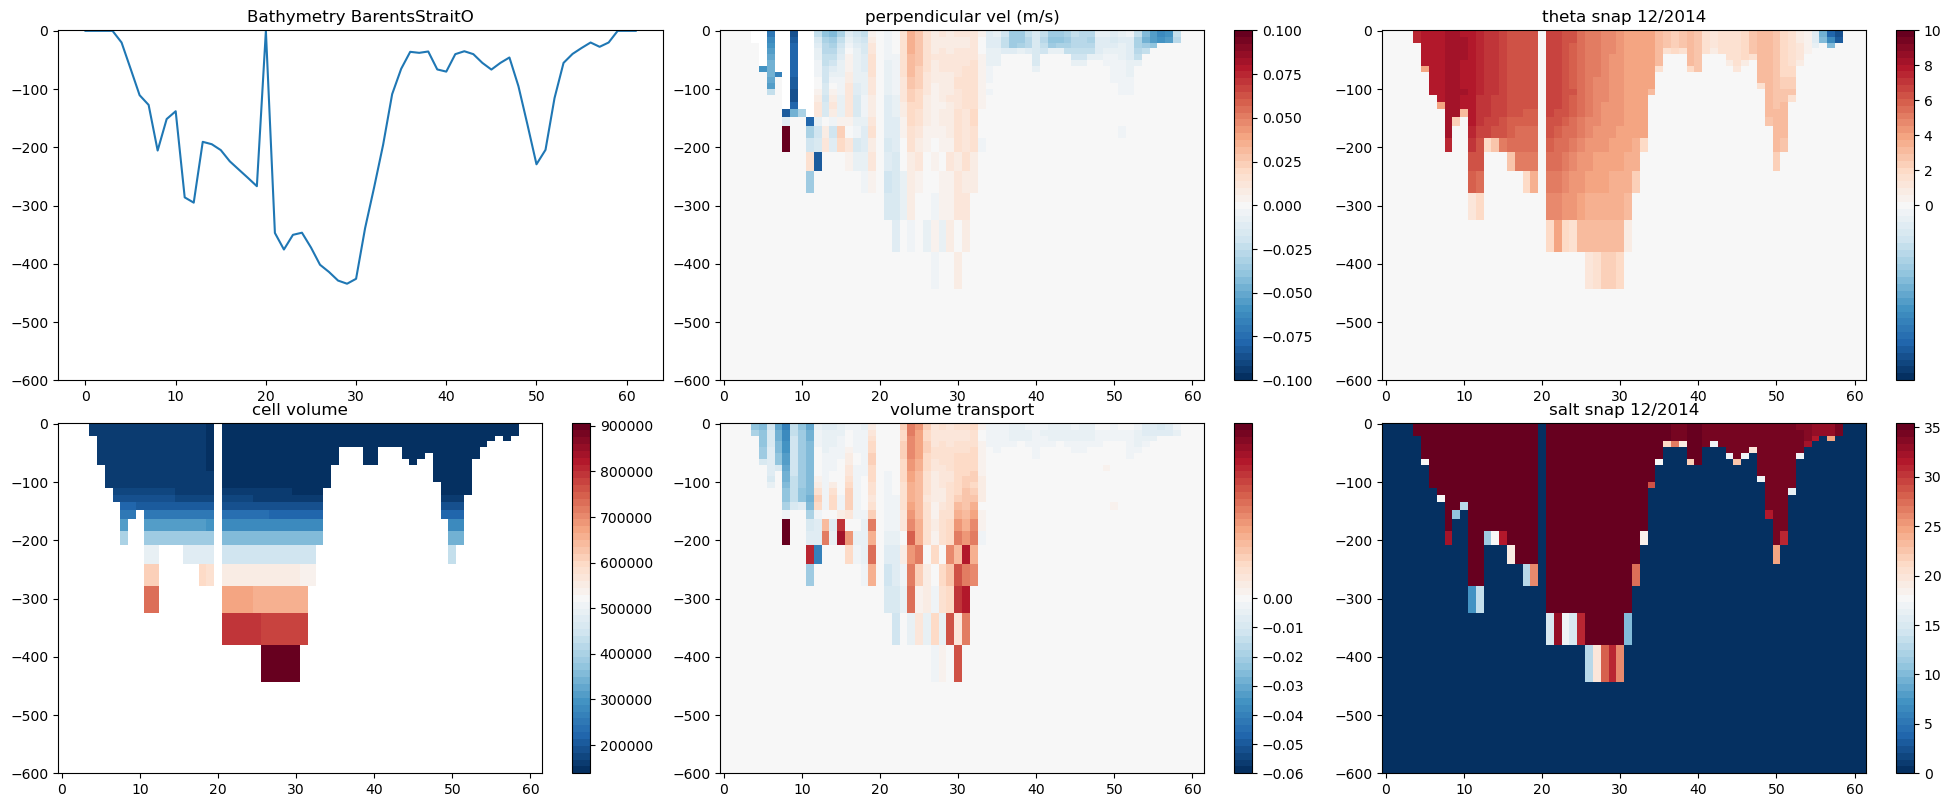

In [74]:
gate = "BarentsStraitO"
indices = np.arange(0,len(y_curr),1)
num_plots = 6
rows = 2
cols = 3
fig,axes = plt.subplots(rows,cols,figsize=(20,8))
fig.tight_layout(pad=1.0)

axes = axes.flatten()
#########################
# bathymetry
ax = axes[0]
ax.plot(indices,-ds.coords["Depth"].values[y_curr,x_curr])
ax.set_ylim(-600,1)
ax.set_title("Bathymetry " + gate)

#########################
# perpendicular vel into BaS
ax = axes[1]
XV,YV= np.meshgrid(indices,mygrid['RC'])
# cb = ax.pcolormesh(XV,YV,ds.UVELMASS.values[:,y_curr,x_curr],cmap=cmap,vmin=0.00001)
norm = TwoSlopeNorm(vmin=-0.1,vcenter=0,vmax=0.1)
cb = ax.pcolormesh(XV,YV,perpendicular_vel,cmap=cmap,norm=norm)
ax.set_title("perpendicular vel (m/s)")
ax.set_ylim(-600,1)
plt.colorbar(cb)

#########################
# theta
ax = axes[2]
XV,YV= np.meshgrid(indices,mygrid['RC'])
snaptheta = ds.theta.values[0]
norm = TwoSlopeNorm(vmin=-1.5,vcenter=0,vmax=10)
cb = ax.pcolormesh(XV,YV,snaptheta[:,y_curr,x_curr],cmap=cmap,norm=norm)
ax.set_title("theta snap 12/2014")
ax.set_ylim(-600,1)
plt.colorbar(cb)


#########################
# test plotting area alone
ax = axes[3]
XV,YV= np.meshgrid(indices,mygrid['RC'])
# cb = ax.pcolormesh(XV,YV,cell_area,cmap=cmap)
cb = ax.pcolormesh(XV,YV,gatemask*cell_area,cmap=cmap)
ax.set_title("cell volume")
ax.set_ylim(-600,1)
plt.colorbar(cb)

#########################
# volume is velocity * cell area
ax = axes[4]
XV,YV= np.meshgrid(indices,mygrid['RC'])
norm = TwoSlopeNorm(vmin=-0.06,vcenter=0,vmax=0.01)
cb = ax.pcolormesh(XV,YV,perpendicular_vel*cell_area*1e-6,cmap=cmap,norm=norm)
ax.set_title("volume transport")
ax.set_ylim(-600,1)
plt.colorbar(cb)

#########################
# salt
ax = axes[5]
XV,YV= np.meshgrid(indices,mygrid['RC'])
snapsalt = ds.SALTDR.values
# cb = ax.pcolormesh(XV,YV,SALTDR[:,y_curr,x_curr]/DRF3d[:,y_curr,x_curr],cmap=cmap)
cb = ax.pcolormesh(XV,YV,SALTDR[:,y_curr,x_curr]/DRF3d[:,y_curr,x_curr],cmap=cmap)

ax.set_title("salt snap 12/2014")
ax.set_ylim(-600,1)
plt.colorbar(cb)

plt.savefig(path + "BSO_testv_theta_salt.png",dpi=300)

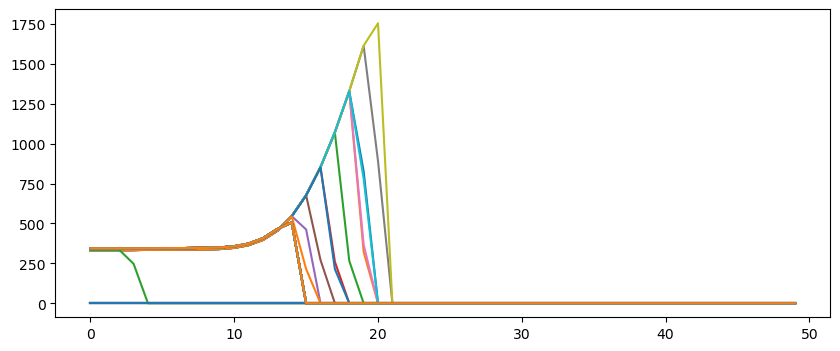

In [75]:
plt.plot(SALTDR[:,y_curr,30])

In [76]:
# # double check this bottom salinity again
# fig = plt.figure(figsize=(5,4))
# plt.pcolormesh(get_aste_tracer(ds.salinity.values[0,22]*mymsk/iB,nfx,nfy)[0])
# plt.xlim(420,540)
# plt.ylim(420,600)
# plt.colorbar()

# Convergences at the gateway for mass

In [77]:
gate_tend = ds.mass_tend.values[:,y_curr,x_curr]
gate_budgO_fluxes_hconv = ds.budgO_fluxes_hconv_mass.values[:,y_curr,x_curr]
gate_budgO_fluxes_zconv = ds.budgO_fluxes_zconv_mass.values[:,y_curr,x_curr]

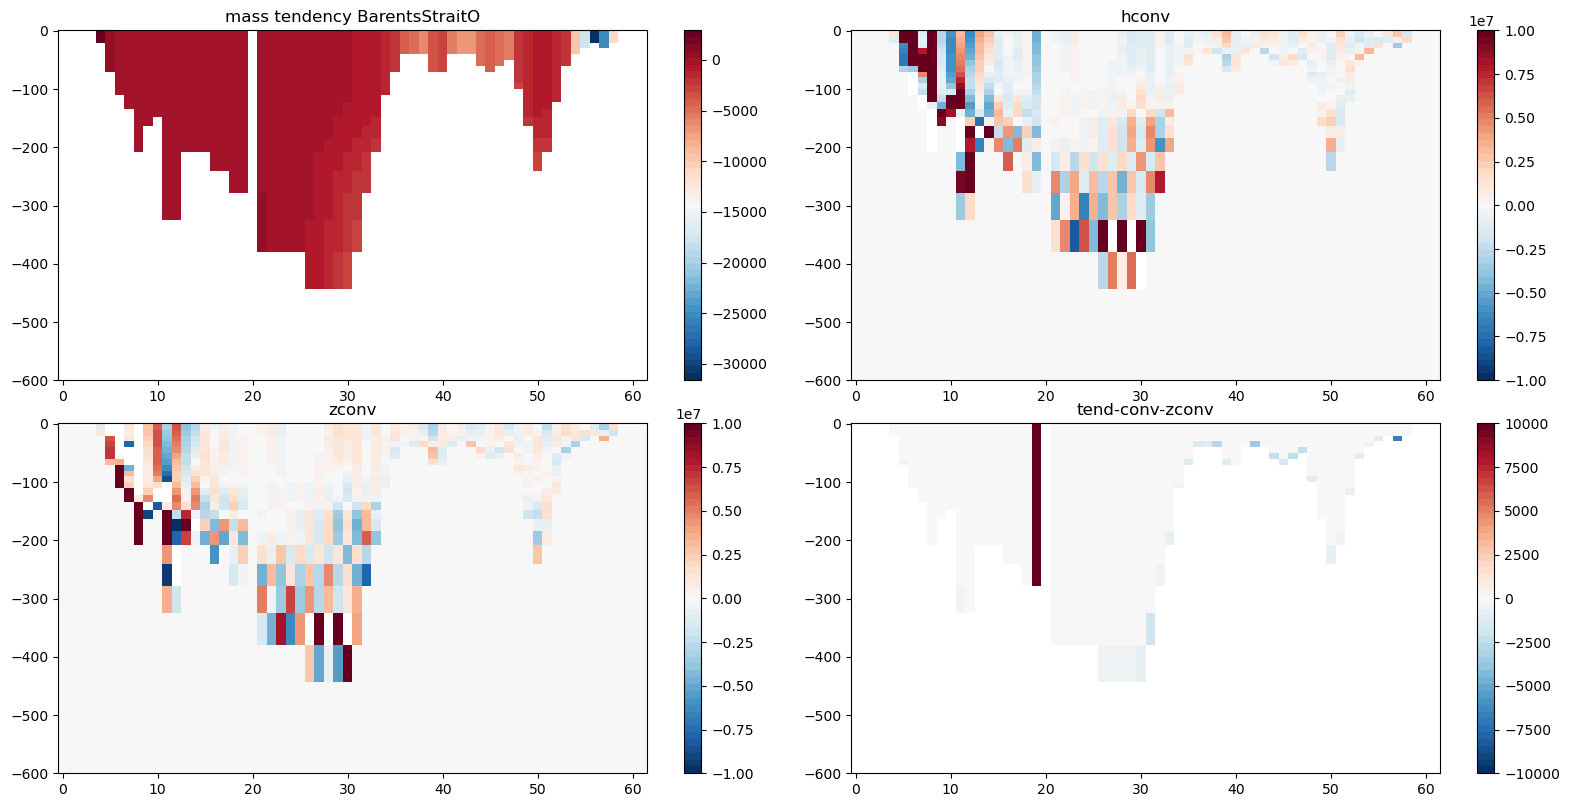

In [78]:
gate = "BarentsStraitO"
indices = np.arange(0,len(y_curr),1)
num_plots = 4
rows = 2
cols = 2
fig,axes = plt.subplots(rows,cols,figsize=(16,8))
fig.tight_layout(pad=1.0)
XV,YV= np.meshgrid(indices,mygrid['RC'])

axes = axes.flatten()
#########################
# bathymetry
ax = axes[0]
norm = TwoSlopeNorm(vmin=-0.1,vcenter=0,vmax=0.1)
cb = ax.pcolormesh(XV,YV,gate_tend,cmap=cmap)
ax.set_title("mass tendency "+gate)
ax.set_ylim(-600,1)
plt.colorbar(cb)

#########################
# perpendicular vel into BaS
ax = axes[1]
norm = TwoSlopeNorm(vmin=-1e7,vcenter=0,vmax=1e7)
cb = ax.pcolormesh(XV,YV,gate_budgO_fluxes_hconv,cmap=cmap,norm=norm)
ax.set_title("hconv")
ax.set_ylim(-600,1)
plt.colorbar(cb)

#########################
# theta
ax = axes[2]
XV,YV= np.meshgrid(indices,mygrid['RC'])
snaptheta = ds.theta.values[0]
norm = TwoSlopeNorm(vmin=-1e7,vcenter=0,vmax=1e7)
cb = ax.pcolormesh(XV,YV,gate_budgO_fluxes_zconv,cmap=cmap,norm=norm)
ax.set_title("zconv")
ax.set_ylim(-600,1)
plt.colorbar(cb)

#########################
# convergence?
ax = axes[3]
# norm = TwoSlopeNorm(vmin=-.0000001,vcenter=0,vmax=.0000001)
cb = ax.pcolormesh(XV,YV,gate_tend-gate_budgO_fluxes_hconv-gate_budgO_fluxes_zconv,cmap=cmap,vmin=-10000,vmax=10000)
ax.set_title("tend-conv-zconv")
ax.set_ylim(-600,1)
plt.colorbar(cb)

plt.savefig(path + "masstend"+gate+".png",dpi=300)

### Plot mass convergence in map view

In [79]:
landmsk = np.full(mygrid['hFacC'].shape, np.nan)
landmsk[np.isnan(mygrid['hFacC'])] = 1
landmsk[~np.isnan(mygrid['hFacC'])] = np.nan

In [80]:
# vars that contribute to mass tend include: oceFWflx,SIatmFW
oceFWflxgate = ds.oceFWflx.values[y_curr,x_curr] * RAC[y_curr,x_curr]
SIatmFWgate = ds.SIatmFW.values[y_curr,x_curr] * RAC[y_curr,x_curr]

In [85]:
tend.shape

(50, 1350, 270)

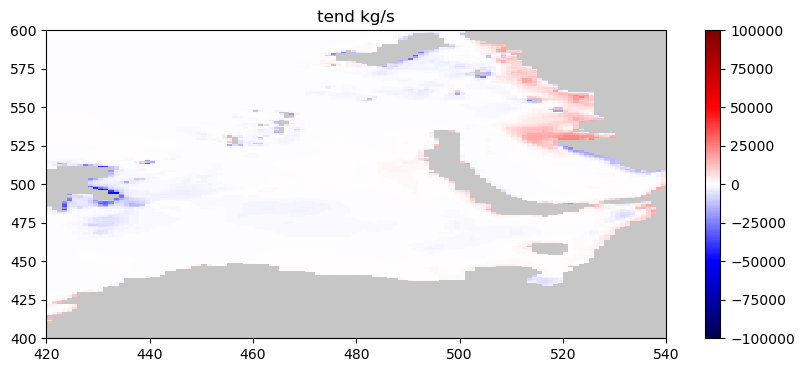

In [89]:
fig = plt.figure()

###
ax = plt.subplot(111)
# plot 1: zconv
valuesz = np.nansum(ds.budgO_fluxes_zconv_mass.values,axis=0)*mymsk/iB  # sum over depth
norm = TwoSlopeNorm(vmin=-1e5,vcenter=0,vmax=1e5)
cb = ax.pcolormesh(get_aste_tracer(ds.mass_tend.values,nfx,nfy)[0],cmap='seismic',norm=norm)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("tend kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

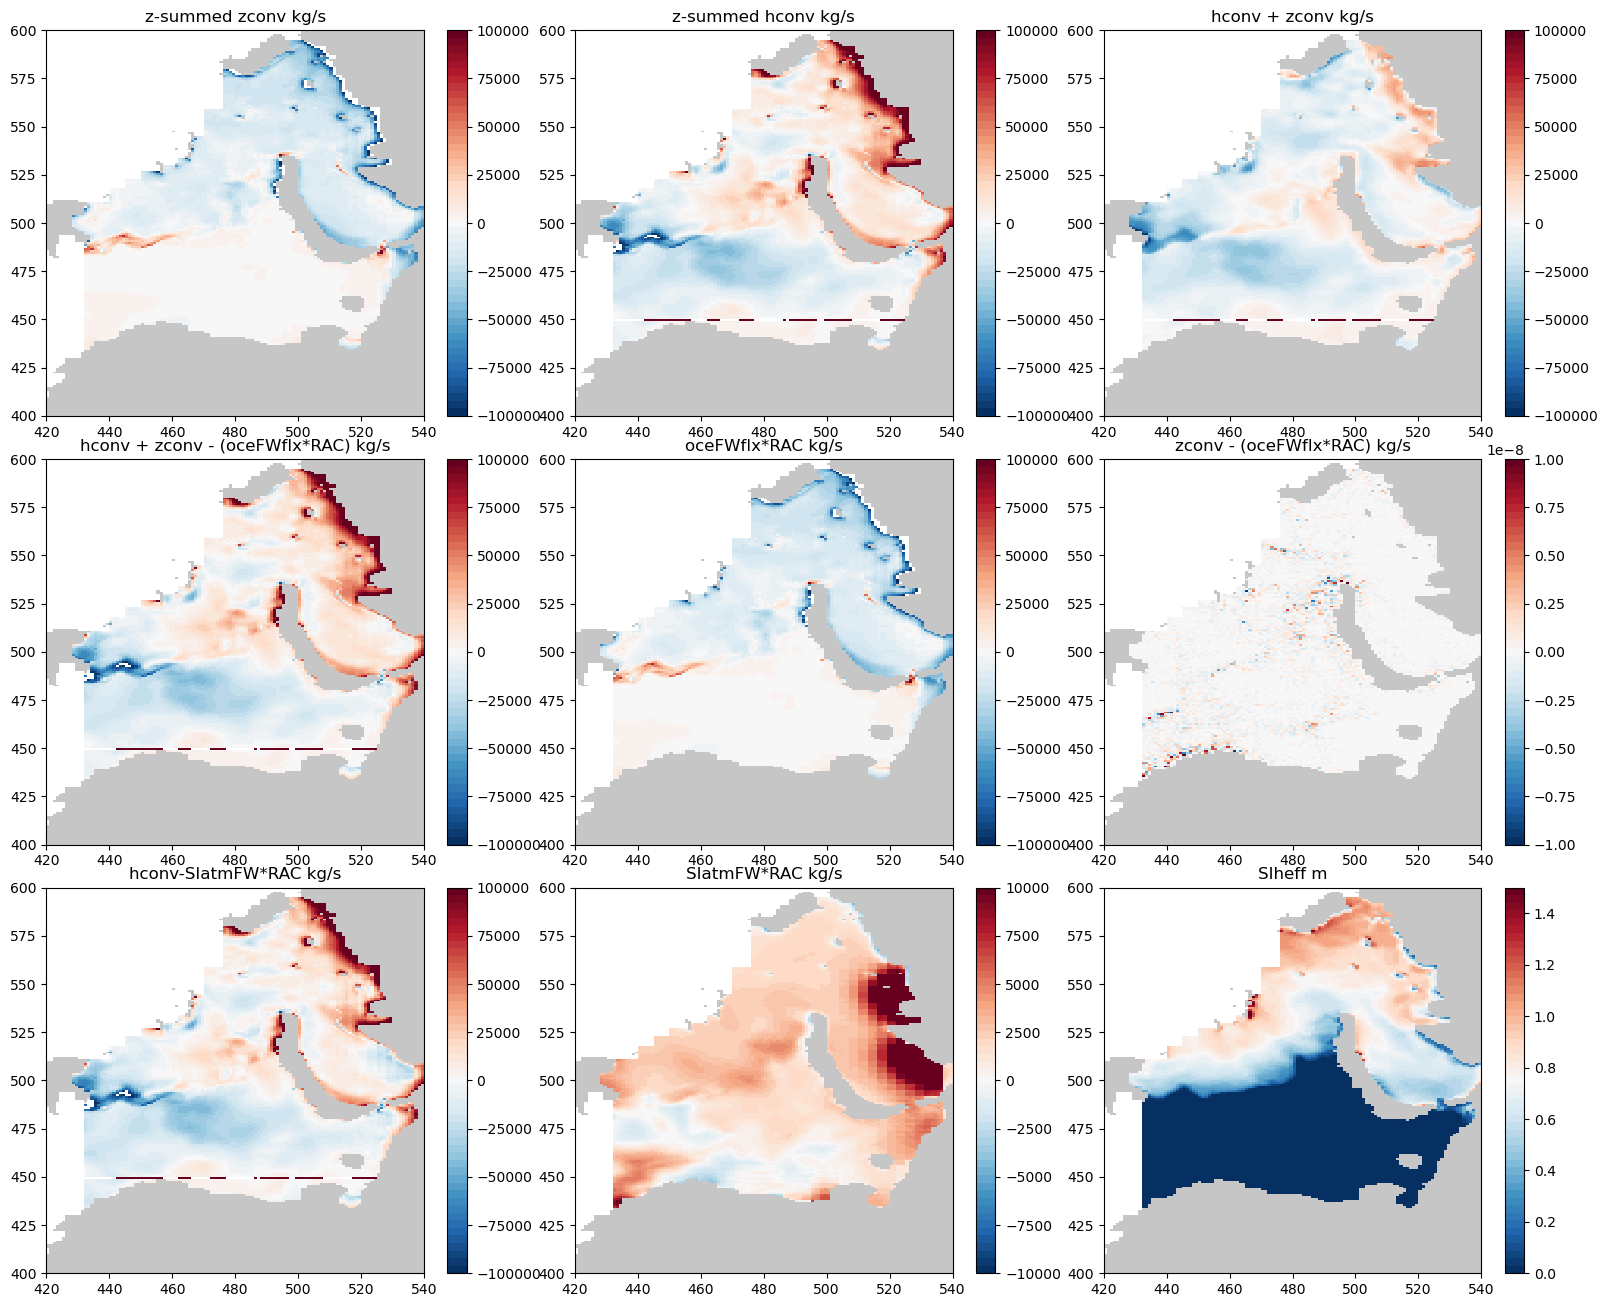

In [82]:
# let's plot the difference in map view as well
num_plots = 9
rows = 3
cols = 3
fig,axes = plt.subplots(rows,cols,figsize=(16,13))
fig.tight_layout(pad=1.0)
XV,YV= np.meshgrid(indices,mygrid['RC'])

axes = axes.flatten()

###
ax = axes[0]
# plot 1: zconv
valuesz = np.nansum(ds.budgO_fluxes_zconv_mass.values,axis=0)*mymsk/iB  # sum over depth
norm = TwoSlopeNorm(vmin=-1e5,vcenter=0,vmax=1e5)
cb = ax.pcolormesh(get_aste_tracer(valuesz,nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("z-summed zconv kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

###
ax = axes[1]
# plot 1: hconv
valuesh = np.nansum(ds.budgO_fluxes_hconv_mass.values,axis=0)*mymsk/iB  # sum over depth
norm = TwoSlopeNorm(vmin=-1e5,vcenter=0,vmax=1e5)
cb = ax.pcolormesh(get_aste_tracer(valuesh*mymsk/iB,nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("z-summed hconv kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

###
ax = axes[2]
# plot 1: hconv + zconv
norm = TwoSlopeNorm(vmin=-100000,vcenter=0,vmax=100000)
cb = ax.pcolormesh(get_aste_tracer(valuesz+valuesh,nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("hconv + zconv kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

###
ax = axes[3]
# plot 1: hconv + zconv - oceFWflx*RAC
norm = TwoSlopeNorm(vmin=-100000,vcenter=0,vmax=100000)
oceFWflxhere = ds.oceFWflx.values * RAC
cb = ax.pcolormesh(get_aste_tracer(valuesz+valuesh - oceFWflxhere,nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("hconv + zconv - (oceFWflx*RAC) kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

###
ax = axes[4]
# plot 1: oceFWflx*RAC
norm = TwoSlopeNorm(vmin=-100000,vcenter=0,vmax=100000)
oceFWflxhere = ds.oceFWflx.values * RAC
cb = ax.pcolormesh(get_aste_tracer(oceFWflxhere * mymsk/iB,nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("oceFWflx*RAC kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

###
ax = axes[5]
# plot 1: zconv - oceFWflx*RAC
norm = TwoSlopeNorm(vmin=-1e-8,vcenter=0,vmax=1e-8)
cb = ax.pcolormesh(get_aste_tracer(valuesz - oceFWflxhere,nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("zconv - (oceFWflx*RAC) kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)
# most of the contribution to zconv is fro the oceFWflx/net surface Fresh-Water flux into the ocean


###
ax = axes[6]
# plot 1: SIatmFW*RAC
norm = TwoSlopeNorm(vmin=-1e5,vcenter=0,vmax=1e5)
SIatmFWhere = ds.SIatmFW.values * RAC
cb = ax.pcolormesh(get_aste_tracer(valuesh - SIatmFWhere*mymsk/iB,nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("hconv-SIatmFW*RAC kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

###
ax = axes[7]
# plot 1: hconv+ zconv - SIatmFW*RAC
norm = TwoSlopeNorm(vmin=-1e4,vcenter=0,vmax=1e4)
cb = ax.pcolormesh(get_aste_tracer(SIatmFWhere* mymsk/iB,nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("SIatmFW*RAC kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

ax = axes[8]
# plot 1: hconv-SIatmFW*RAC
norm = TwoSlopeNorm(vmin=-1e4,vcenter=0,vmax=1e4)
cb = ax.pcolormesh(get_aste_tracer(ds.SIheff.values[0]*mymsk/iB,nfx,nfy)[0],cmap=cmap,vmin=0,vmax=1.5)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("SIheff m")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

# ###
# ax = axes[6]
# # plot 1: SIatmFW*RAC
# norm = TwoSlopeNorm(vmin=-1e7,vcenter=0,vmax=1e7)
# SIatmFWhere = ds.SIatmFW.values * RAC
# cb = ax.pcolormesh(get_aste_tracer(SIatmFWhere* mymsk/iB,nfx,nfy)[0],cmap=cmap,vmin=0,vmax=1e4)
# ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
# ax.set_title("SIatmFW*RAC kg/s")
# ax.set_xlim(420,540)
# ax.set_ylim(400,600)
# plt.colorbar(cb)

# ###
# ax = axes[7]
# # plot 1: hconv+ zconv - SIatmFW*RAC
# norm = TwoSlopeNorm(vmin=-1e4,vcenter=0,vmax=1e4)
# cb = ax.pcolormesh(get_aste_tracer(valuesz+valuesh - (SIatmFWhere* mymsk/iB),nfx,nfy)[0],cmap=cmap,norm=norm)
# ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
# ax.set_title("zconv+hconv-SIatmFW*RAC kg/s")
# ax.set_xlim(420,540)
# ax.set_ylim(400,600)
# plt.colorbar(cb)

# ax = axes[8]
# # plot 1: hconv-SIatmFW*RAC
# norm = TwoSlopeNorm(vmin=-1e4,vcenter=0,vmax=1e4)
# cb = ax.pcolormesh(get_aste_tracer(valuesh - (SIatmFWhere* mymsk/iB),nfx,nfy)[0],cmap=cmap,norm=norm)
# ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
# ax.set_title("hconv-SIatmFW*RAC kg/s")
# ax.set_xlim(420,540)
# ax.set_ylim(400,600)
# plt.colorbar(cb)


plt.savefig(path + "3by3comp_mass_tend4.png",dpi=300)

In [ ]:
WTHMASS.shape

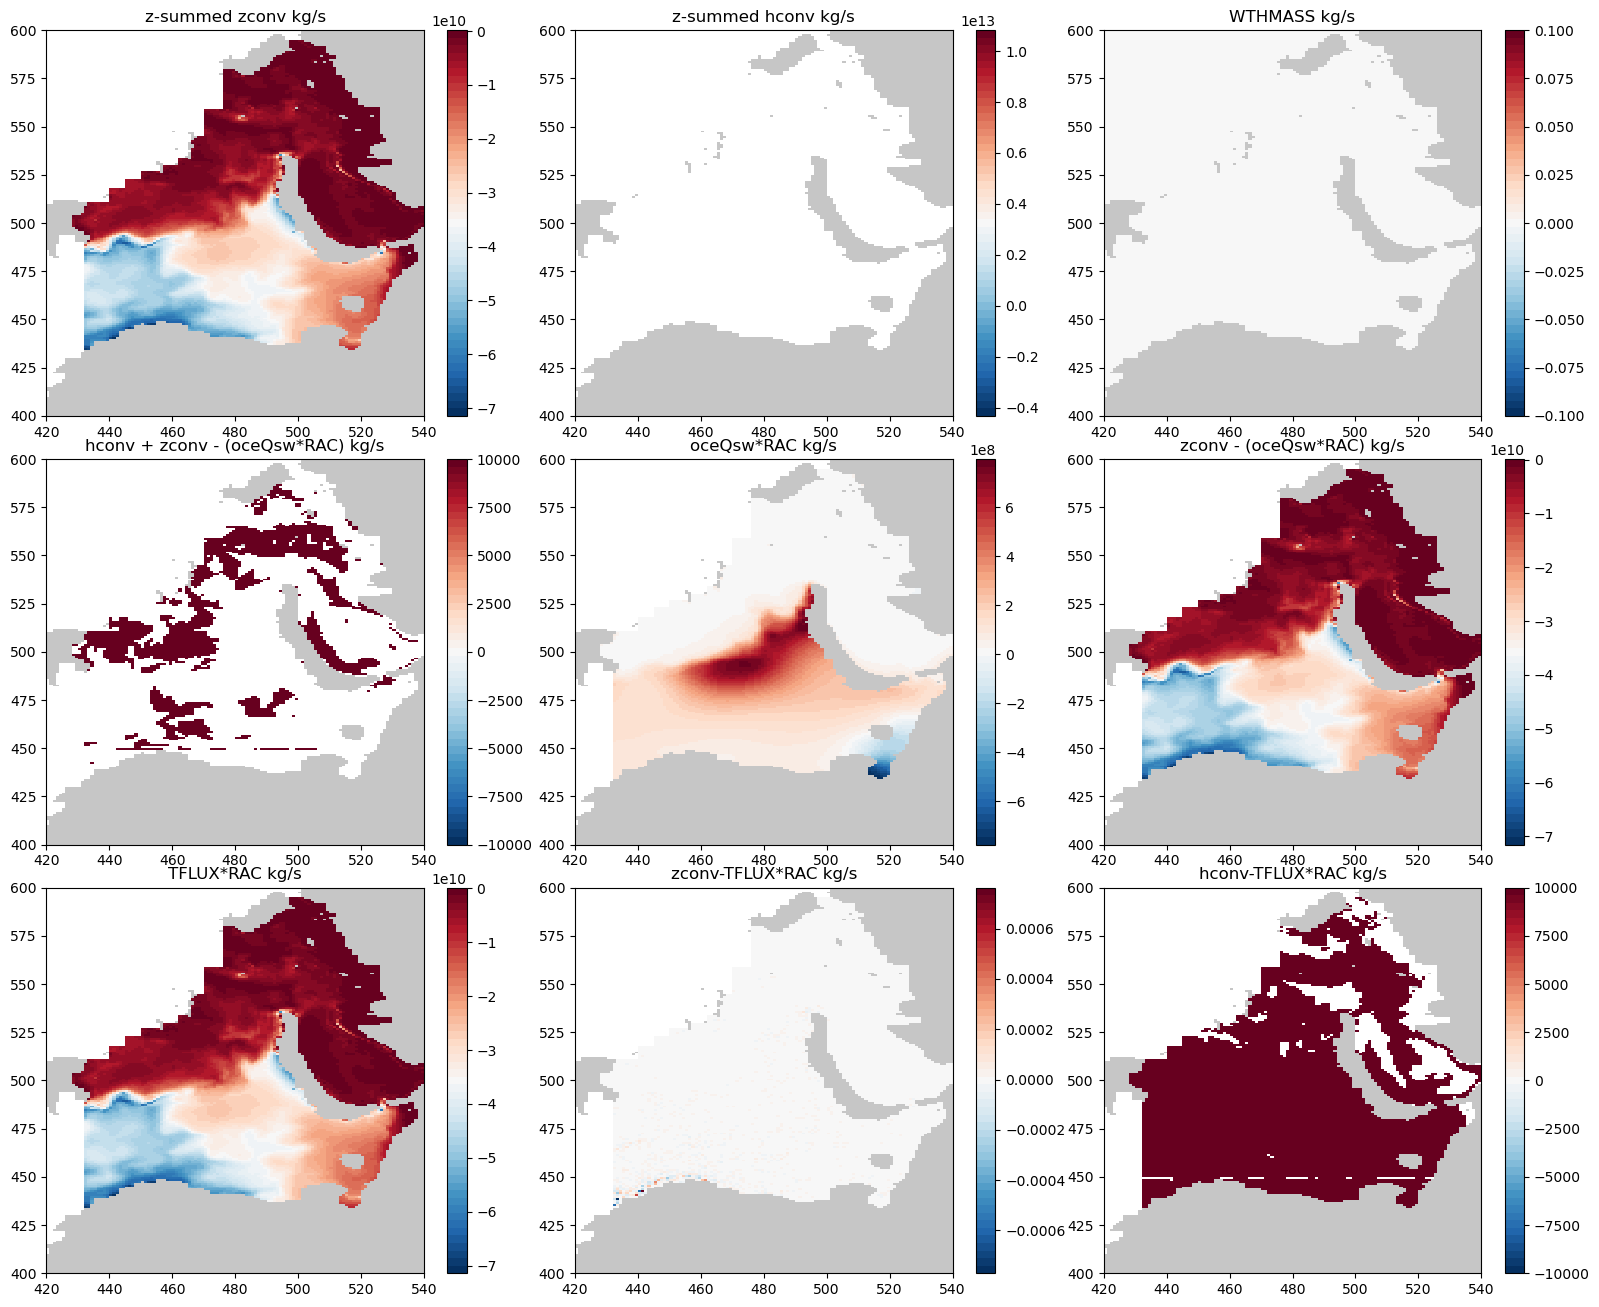

In [82]:
# vars that contribute to heat tend include: TFLUX, oceQsw, WTHMASS

# let's plot the difference in map view as well
num_plots = 9
rows = 3
cols = 3
fig,axes = plt.subplots(rows,cols,figsize=(16,13))
fig.tight_layout(pad=1.0)
XV,YV= np.meshgrid(indices,mygrid['RC'])

axes = axes.flatten()

###
ax = axes[0]
# plot 1: zconv
valuesz = np.nansum(ds.budgO_fluxes_zconv_heat.values,axis=0)*mymsk/iB  # sum over depth
norm = TwoSlopeNorm(vmin=-1e5,vcenter=0,vmax=1e5)
cb = ax.pcolormesh(get_aste_tracer(valuesz,nfx,nfy)[0],cmap=cmap)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("z-summed zconv kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

###
ax = axes[1]
# plot 1: hconv
valuesh = np.nansum(ds.budgO_fluxes_hconv_heat.values,axis=0)*mymsk/iB  # sum over depth
norm = TwoSlopeNorm(vmin=-1e4,vcenter=0,vmax=1e4)
cb = ax.pcolormesh(get_aste_tracer(valuesh*mymsk/iB,nfx,nfy)[0][:,450:],cmap=cmap)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("z-summed hconv kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

###
ax = axes[2]
# plot 1: hconv + zconv
norm = TwoSlopeNorm(vmin=-100000,vcenter=0,vmax=100000)
WTHMASS = WTHMASS.reshape(ny,nx)
cb = ax.pcolormesh(get_aste_tracer(WTHMASS,nfx,nfy)[0],cmap=cmap)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("WTHMASS kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

###
ax = axes[3]
# plot 1: hconv + zconv - oceFWflx*RAC
norm = TwoSlopeNorm(vmin=-1e4,vcenter=0,vmax=1e4)
oceQswhere = oceQsw * RAC
cb = ax.pcolormesh(get_aste_tracer(valuesz+valuesh - oceQswhere,nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("hconv + zconv - (oceQsw*RAC) kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

###
ax = axes[4]
# plot 1: oceFWflx*RAC
norm = TwoSlopeNorm(vmin=-1,vcenter=0,vmax=10000)
cb = ax.pcolormesh(get_aste_tracer(oceQswhere * mymsk/iB,nfx,nfy)[0],cmap=cmap)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("oceQsw*RAC kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

###
ax = axes[5]
# plot 1: zconv - oceFWflx*RAC
norm = TwoSlopeNorm(vmin=-1e7,vcenter=0,vmax=1e7)
cb = ax.pcolormesh(get_aste_tracer(valuesz - oceQswhere,nfx,nfy)[0],cmap=cmap)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("zconv - (oceQsw*RAC) kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)
# most of the contribution to zconv is fro the oceFWflx/net surface Fresh-Water flux into the ocean

###
ax = axes[6]
# plot 1: SIatmFW*RAC
norm = TwoSlopeNorm(vmin=-1e7,vcenter=0,vmax=1e7)
TFLUXhere = TFLUX * RAC
cb = ax.pcolormesh(get_aste_tracer(TFLUXhere* mymsk/iB,nfx,nfy)[0],cmap=cmap)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("TFLUX*RAC kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

### d
ax = axes[7]
# plot 1: hconv+ zconv - SIatmFW*RAC
norm = TwoSlopeNorm(vmin=-1e4,vcenter=0,vmax=1e4)
cb = ax.pcolormesh(get_aste_tracer(valuesz - (TFLUXhere* mymsk/iB),nfx,nfy)[0],cmap=cmap)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("zconv-TFLUX*RAC kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

ax = axes[8]
# plot 1: hconv-SIatmFW*RAC
norm = TwoSlopeNorm(vmin=-1e4,vcenter=0,vmax=1e4)
cb = ax.pcolormesh(get_aste_tracer(valuesh - (TFLUXhere* mymsk/iB),nfx,nfy)[0],cmap=cmap,norm=norm)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("hconv-TFLUX*RAC kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)


plt.savefig(path + "3by3comp_heat_tend.png",dpi=300)

In [90]:
test = valuesh*mymsk/iB
print(np.nanmax(test)/1e12,np.nanmin(test)/1e12)

10.8158821996919 -4.388468833385053


(400.0, 600.0)

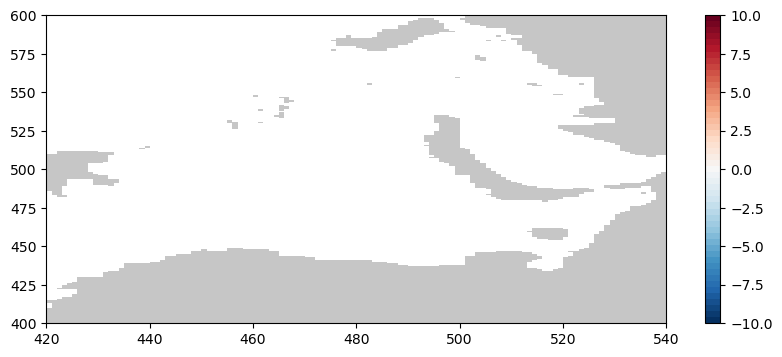

In [88]:

# ax = axes[1]
# # plot 1: hconv
# valuesh = np.nansum(ds.budgO_fluxes_hconv_heat.values,axis=0)*mymsk/iB  # sum over depth
# norm = TwoSlopeNorm(vmin=-1e4,vcenter=0,vmax=1e4)
plt.pcolormesh(get_aste_tracer(valuesh*mymsk/iB,nfx,nfy)[0][455:,:],cmap=cmap,vmin=-10,vmax=10)
plt.colorbar()
plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
# ax.set_title("z-summed hconv kg/s")
plt.xlim(420,540)
plt.ylim(400,600)


In [96]:
vals = ds.budgO_fluxes_hconv_heat.values * mymsk[np.newaxis,:,:]/iB
np.nanmax(vals)
# np.where(vals == 112466248868722.17)

3817073630301.6206

In [ ]:
# try again with just 1 by 3

# vars that contribute to heat tend include: TFLUX, oceQsw, WTHMASS

# let's plot the difference in map view as well
num_plots = 3
rows = 1
cols = 3
fig,axes = plt.subplots(rows,cols,figsize=(16,4))
fig.tight_layout(pad=1.0)
XV,YV= np.meshgrid(indices,mygrid['RC'])

axes = axes.flatten()

###
ax = axes[0]
# plot 1: zconv
valuesz = np.nansum(ds.budgO_fluxes_zconv_heat.values,axis=0)*mymsk/iB  # sum over depth
norm = TwoSlopeNorm(vmin=-1e5,vcenter=0,vmax=1e5)
cb = ax.pcolormesh(get_aste_tracer(valuesz,nfx,nfy)[0],cmap=cmap)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("z-summed zconv kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)
###
ax = axes[1]
# plot 1: SIatmFW*RAC
norm = TwoSlopeNorm(vmin=-1e7,vcenter=0,vmax=1e7)
TFLUXhere = TFLUX * RAC
cb = ax.pcolormesh(get_aste_tracer(TFLUXhere* mymsk/iB,nfx,nfy)[0],cmap=cmap)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("TFLUX*RAC kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

### d
ax = axes[2]
# plot 1: hconv+ zconv - SIatmFW*RAC
norm = TwoSlopeNorm(vmin=-1e4,vcenter=0,vmax=1e4)
cb = ax.pcolormesh(get_aste_tracer(valuesz - (TFLUXhere* mymsk/iB),nfx,nfy)[0],cmap=cmap)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.2)
ax.set_title("zconv-TFLUX*RAC kg/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)
plt.colorbar(cb)


plt.savefig(path + "1by3comp_heat_tend.png",dpi=300)